## Introducing Data Science Workflows

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils import np_utils
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Using TensorFlow backend.


In [2]:
# import warnings
# warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='ignore',category=DeprecationWarning)

# import pandas as pd

train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")

In [3]:
train.shape


(891, 12)

In [4]:
holdout.shape

(418, 11)

## Preprocessing the Data

In [5]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [6]:
def pre_process(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)

    for col in ["Age_categories","Fare_categories",
                "Title","Cabin_type","Sex"]:
        df = create_dummies(df,col)
    
    return df

train = pre_process(train)
holdout = pre_process(holdout)

## Exploring the Data

In [7]:
explore_cols = ["SibSp","Parch","Survived"]
explore = train[explore_cols].copy()
explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   SibSp     891 non-null    int64
 1   Parch     891 non-null    int64
 2   Survived  891 non-null    int64
dtypes: int64(3)
memory usage: 21.0 KB


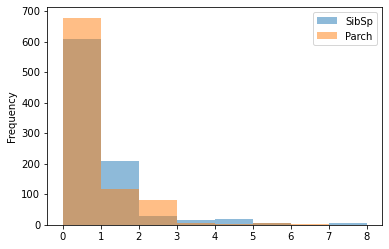

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

explore.drop("Survived",axis=1).plot.hist(alpha=0.5,bins=8)
plt.show()

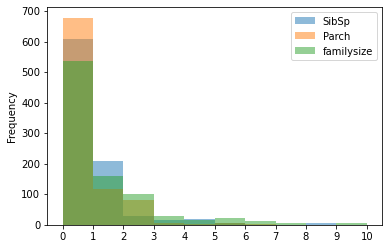

In [9]:
explore["familysize"] = explore[["SibSp","Parch"]].sum(axis=1)
explore.drop("Survived",axis=1).plot.hist(alpha=0.5,bins=10)
plt.xticks(range(11))
plt.show()

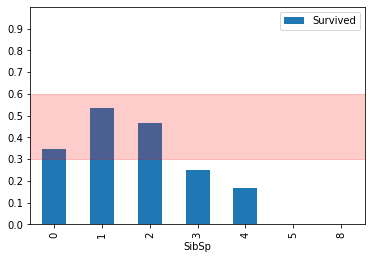

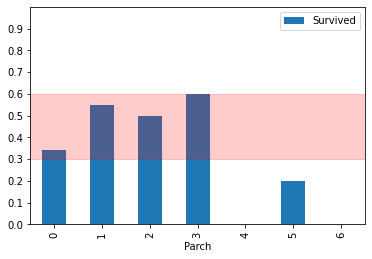

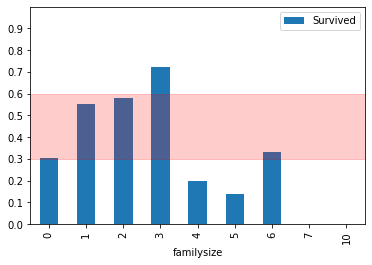

In [10]:
import numpy as np

for col in explore.columns.drop("Survived"):
    pivot = explore.pivot_table(index=col,values="Survived")
    pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
    plt.axhspan(.3, .6, alpha=0.2, color='red')
    plt.show()

The `SibSp` column shows the number of siblings and/or spouses each passenger had on board, while the `Parch` columns shows the number of parents or children each passenger had onboard. Neither column has any missing values.

The distribution of values in both columns is skewed right, with the majority of values being zero.

You can sum these two columns to explore the total number of family members each passenger had onboard.  The shape of the distribution of values in this case is similar, however there are less values at zero, and the quantity tapers off less rapidly as the values increase.

Looking at the survival rates of the the combined family members, you can see that few of the over 500 passengers with no family members survived, while greater numbers of passengers with family members survived.

## Engineering New Features

In [11]:
def process_isalone(df):
    df["familysize"] = df[["SibSp","Parch"]].sum(axis=1)
    df["isalone"] = 0
    df.loc[(df["familysize"] == 0),"isalone"] = 1
    df = df.drop("familysize",axis=1)
    return df

train = process_isalone(train)
holdout = process_isalone(holdout)

In [12]:
holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_categories,Fare_categories,Title,Cabin_type,Age_categories_Missing,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,Age_categories_Young Adult,Age_categories_Adult,Age_categories_Senior,Fare_categories_0-12,Fare_categories_12-50,Fare_categories_50-100,Fare_categories_100+,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Cabin_type_A,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_Unknown,Sex_female,Sex_male,isalone
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,Young Adult,0-12,Mr,Unknown,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,Adult,0-12,Mrs,Unknown,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,Senior,0-12,Mr,Unknown,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,Young Adult,0-12,Mr,Unknown,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,Young Adult,12-50,Mrs,Unknown,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0


In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 44 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   PassengerId                 891 non-null    int64   
 1   Survived                    891 non-null    int64   
 2   Pclass                      891 non-null    int64   
 3   Name                        891 non-null    object  
 4   Sex                         891 non-null    object  
 5   Age                         891 non-null    float64 
 6   SibSp                       891 non-null    int64   
 7   Parch                       891 non-null    int64   
 8   Ticket                      891 non-null    object  
 9   Fare                        891 non-null    float64 
 10  Embarked                    891 non-null    object  
 11  Age_categories              891 non-null    category
 12  Fare_categories             891 non-null    category
 13  Title               

In [14]:
train.drop(columns=['Name','Sex','Ticket','Embarked','Age_categories','Fare_categories', 'Title' ,'Cabin_type'], axis=1, inplace=True)

In [15]:
holdout.drop(columns=['Name','Sex','Ticket','Embarked','Age_categories','Fare_categories', 'Title' ,'Cabin_type'], axis=1, inplace=True)

In [16]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Age_categories_Missing,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,Age_categories_Young Adult,Age_categories_Adult,Age_categories_Senior,Fare_categories_0-12,Fare_categories_12-50,Fare_categories_50-100,Fare_categories_100+,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Cabin_type_A,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Sex_female,Sex_male,isalone
0,1,0,3,22.0,1,0,7.2500,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,2,1,1,38.0,1,0,71.2833,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,5,0,3,35.0,0,0,8.0500,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1


## Selecting the Best-Performing Features

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

def select_features(df):
    # Remove non-numeric columns, columns that have null values
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(["Survived","PassengerId"],axis=1)
    all_y = df["Survived"]
    
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf,cv=10)
    selector.fit(all_X,all_y)
    
    best_columns = list(all_X.columns[selector.support_])
    print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))
    
    return best_columns

cols = select_features(train)

Best Columns 
------------
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Child', 'Age_categories_Teenager', 'Age_categories_Young Adult', 'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12', 'Fare_categories_12-50', 'Fare_categories_50-100', 'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'isalone']



In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
scaler = StandardScaler()



## Selecting and Tuning Different Algorithms

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

def select_model(df,features):
    
#     all_X = scaler.fit_transform(df[features])
#     all_y = df["Survived"]
    
    all_X = df[features]
    all_y = df["Survived"]

    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=42),
            "hyperparameters":
                {
                    "n_estimators": [5, 50, 110],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10, 20, None],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]

                }
        },
        {
            "name": "SVC",
            "estimator": SVC(),
            "hyperparameters":
                {
                    "C": [0.05,0.10,0.15,0.25,0.30] ,
                    "kernel":["linear","sigmoid"]
                }
        }
    
    ]

    for model in models:
        print(model['name'])
        print('-'*len(model['name']))

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10)
        grid.fit(all_X,all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models

result = select_model(train,cols)

LogisticRegression
------------------
Best Score: 0.8204264870931538
Best Parameters: {'solver': 'liblinear'}

KNeighborsClassifier
--------------------


C:\Users\naim_\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Score: 0.7755331088664422
Best Parameters: {'algorithm': 'brute', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}

RandomForestClassifier
----------------------
Best Score: 0.8428731762065096
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 110}

SVC
---
Best Score: 0.813692480359147
Best Parameters: {'C': 0.15, 'kernel': 'linear'}



## Making a Submission to Kaggle

In [32]:
def save_submission_file(model,cols,filename="submission_3.csv"):
    holdout_data = holdout[cols]
    predictions = model.predict(holdout_data)
    
    holdout_ids = holdout["PassengerId"]
    submission_df = {"PassengerId": holdout_ids,
                 "Survived": predictions}
    submission = pd.DataFrame(submission_df)

    submission.to_csv(filename,index=False)

best_rf_model = result[3]["best_model"]
save_submission_file(best_rf_model,cols)

In [33]:
best_rf_model

SVC(C=0.15, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [17]:
# Neural Network

X_train= train.drop(['PassengerId','Survived','Cabin_type_T'], axis=1)
y_train = train['Survived']
X_test = holdout.drop(['PassengerId'], axis=1)


In [18]:
X_train.columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Cabin_type_A',
       'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E',
       'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_Unknown', 'Sex_female',
       'Sex_male', 'isalone'],
      dtype='object')

In [19]:
X_test.columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Cabin_type_A',
       'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E',
       'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_Unknown', 'Sex_female',
       'Sex_male', 'isalone'],
      dtype='object')

In [20]:
# Initialize StandardScaler
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()

# Transform the training data
X_train_sc = sc.fit_transform(X_train)
X_train_sc = pd.DataFrame(X_train_sc,columns=X_test.columns)

# Transform the testing data
X_test_sc=sc.transform(X_test)
X_test_sc=pd.DataFrame(X_test_sc,columns=X_train.columns)

In [97]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow import random
from tensorflow.keras.optimizers import SGD

seed = 42
random.set_seed(seed)
np.random.seed(seed)
model = Sequential()

# Add the hidden dense layers and with dropout Layer
model.add(Dense(units=512, activation='relu', kernel_initializer='he_uniform', input_dim=X_train_sc.shape[1]))
model.add(Dropout(rate=0.5))
model.add(Dense(units=128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(rate=0.4))
model.add(Dense(units=64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(rate=0.3))
model.add(Dense(units=32, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=16, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(rate=0.1))
model.add(Dense(units=8, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(rate=0.1))

# Add Output Dense Layer
model.add(Dense(units=1, activation='sigmoid'))


In [32]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow import random
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

# # from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.model_selection import GridSearchCV


l2_param = 0.005
seed = 42
random.set_seed(seed)
np.random.seed(seed)


def build_model(lambda_parameter):
    model = Sequential()
    # Add the hidden dense layers and with dropout Layer
    model.add(Dense(units=512, activation='relu', kernel_regularizer=l2(lambda_parameter), input_dim=X_train_sc.shape[1]))

    model.add(Dense(units=128, activation='relu', kernel_regularizer=l2(lambda_parameter)))

    model.add(Dense(units=64, activation='relu', kernel_regularizer=l2(lambda_parameter)))

    model.add(Dense(units=32, activation='relu', kernel_regularizer=l2(lambda_parameter)))

    model.add(Dense(units=16, activation='relu', kernel_regularizer=l2(lambda_parameter)))

    model.add(Dense(units=8, activation='relu', kernel_regularizer=l2(lambda_parameter)))


    # Add Output Dense Layer
    model.add(Dense(units=1, activation='sigmoid'))
    
    opt = SGD(lr=0.001, momentum=0.9)
    
    # Compile the Model
    model.compile(optimizer= opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model
    

In [35]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
# define a seed for random number generator so the result will be reproducible
import numpy as np
from tensorflow import random

seed = 1
np.random.seed(seed)
random.set_seed(seed)
# create the Keras wrapper with scikit learn
model = KerasClassifier(build_fn=build_model, verbose=0)
# define all the possible values for each hyperparameter
lambda_parameter = [0.001, 0.01, 0.05, 0.1] #[0.01, 0.5, 1]
epochs = [50, 100, 200]
batch_size = [20]
# create the dictionary containing all possible values of hyperparameters
param_grid = dict(lambda_parameter=lambda_parameter, epochs=epochs, batch_size=batch_size)
# perform 5-fold cross validation for ??????? store the results
grid_seach = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
results_1 = grid_seach.fit(X_train_sc, y_train)

In [36]:
# print the results for best cross validation score
print("Best cross validation score =", results_1.best_score_)
print("Parameters for Best cross validation scor e=", results_1.best_params_)

# print the results for all evaluated hyperparameter combinations
accuracy_means = results_1.cv_results_['mean_test_score']
accuracy_stds = results_1.cv_results_['std_test_score']
parameters = results_1.cv_results_['params']
for p in range(len(parameters)):
    print("Accuracy %f (std %f) for params %r" % (accuracy_means[p], accuracy_stds[p], parameters[p]))

Best cross validation score = 0.8148640990257263
Parameters for Best cross validation scor e= {'batch_size': 20, 'epochs': 200, 'lambda_parameter': 0.001}
Accuracy 0.811487 (std 0.039755) for params {'batch_size': 20, 'epochs': 50, 'lambda_parameter': 0.001}
Accuracy 0.810370 (std 0.047374) for params {'batch_size': 20, 'epochs': 50, 'lambda_parameter': 0.01}
Accuracy 0.732955 (std 0.063648) for params {'batch_size': 20, 'epochs': 50, 'lambda_parameter': 0.05}
Accuracy 0.616101 (std 0.039684) for params {'batch_size': 20, 'epochs': 50, 'lambda_parameter': 0.1}
Accuracy 0.807005 (std 0.043056) for params {'batch_size': 20, 'epochs': 100, 'lambda_parameter': 0.001}
Accuracy 0.809246 (std 0.046520) for params {'batch_size': 20, 'epochs': 100, 'lambda_parameter': 0.01}
Accuracy 0.758691 (std 0.060221) for params {'batch_size': 20, 'epochs': 100, 'lambda_parameter': 0.05}
Accuracy 0.616101 (std 0.039684) for params {'batch_size': 20, 'epochs': 100, 'lambda_parameter': 0.1}
Accuracy 0.814864

In [38]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow import random
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

# # from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.model_selection import GridSearchCV


lambda_parameter = 0.001
seed = 42
random.set_seed(seed)
np.random.seed(seed)



model = Sequential()
# Add the hidden dense layers and with dropout Layer
model.add(Dense(units=512, activation='relu', kernel_regularizer=l2(lambda_parameter), input_dim=X_train_sc.shape[1]))

model.add(Dense(units=128, activation='relu', kernel_regularizer=l2(lambda_parameter)))

model.add(Dense(units=64, activation='relu', kernel_regularizer=l2(lambda_parameter)))

model.add(Dense(units=32, activation='relu', kernel_regularizer=l2(lambda_parameter)))

model.add(Dense(units=16, activation='relu', kernel_regularizer=l2(lambda_parameter)))

model.add(Dense(units=8, activation='relu', kernel_regularizer=l2(lambda_parameter)))


# Add Output Dense Layer
model.add(Dense(units=1, activation='sigmoid'))

opt = SGD(lr=0.001, momentum=0.9)

# Compile the Model
model.compile(optimizer= opt, loss='binary_crossentropy', metrics=['accuracy'])
    
 
    

In [39]:
model.summary()

Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_644 (Dense)            (None, 512)               17408     
_________________________________________________________________
dense_645 (Dense)            (None, 128)               65664     
_________________________________________________________________
dense_646 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_647 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_648 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_649 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_650 (Dense)            (None, 1)               

In [40]:
history = model.fit(X_train_sc, y_train, epochs=200, batch_size=20, verbose=1, shuffle=False)

Epoch 1/200
45/45 [==============================] - 0s 3ms/step - loss: 1.1110 - accuracy: 0.6128
Epoch 2/200
45/45 [==============================] - 0s 3ms/step - loss: 1.0990 - accuracy: 0.6162
Epoch 3/200
45/45 [==============================] - 0s 3ms/step - loss: 1.0863 - accuracy: 0.6162
Epoch 4/200
45/45 [==============================] - 0s 2ms/step - loss: 1.0735 - accuracy: 0.6162
Epoch 5/200
45/45 [==============================] - 0s 3ms/step - loss: 1.0581 - accuracy: 0.6162
Epoch 6/200
45/45 [==============================] - 0s 2ms/step - loss: 1.0385 - accuracy: 0.6162
Epoch 7/200
45/45 [==============================] - 0s 2ms/step - loss: 1.0160 - accuracy: 0.6162
Epoch 8/200
45/45 [==============================] - 0s 3ms/step - loss: 0.9927 - accuracy: 0.6240
Epoch 9/200
45/45 [==============================] - 0s 2ms/step - loss: 0.9665 - accuracy: 0.6958
Epoch 10/200
45/45 [==============================] - 0s 3ms/step - loss: 0.9380 - accuracy: 0.7890
Epoch 11/

45/45 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.8911
Epoch 83/200
45/45 [==============================] - 0s 3ms/step - loss: 0.6492 - accuracy: 0.8911
Epoch 84/200
45/45 [==============================] - 0s 3ms/step - loss: 0.6484 - accuracy: 0.8900
Epoch 85/200
45/45 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.8900
Epoch 86/200
45/45 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.8900
Epoch 87/200
45/45 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.8911
Epoch 88/200
45/45 [==============================] - 0s 3ms/step - loss: 0.6447 - accuracy: 0.8889
Epoch 89/200
45/45 [==============================] - 0s 2ms/step - loss: 0.6439 - accuracy: 0.8900
Epoch 90/200
45/45 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.8889
Epoch 91/200
45/45 [==============================] - 0s 3ms/step - loss: 0.6421 - accuracy: 0.8900
Epoch 92/200


45/45 [==============================] - 0s 2ms/step - loss: 0.5880 - accuracy: 0.8911
Epoch 164/200
45/45 [==============================] - 0s 2ms/step - loss: 0.5873 - accuracy: 0.8878
Epoch 165/200
45/45 [==============================] - 0s 2ms/step - loss: 0.5869 - accuracy: 0.8889
Epoch 166/200
45/45 [==============================] - 0s 2ms/step - loss: 0.5859 - accuracy: 0.8945
Epoch 167/200
45/45 [==============================] - 0s 2ms/step - loss: 0.5856 - accuracy: 0.8911
Epoch 168/200
45/45 [==============================] - 0s 3ms/step - loss: 0.5848 - accuracy: 0.8934
Epoch 169/200
45/45 [==============================] - 0s 3ms/step - loss: 0.5839 - accuracy: 0.8911
Epoch 170/200
45/45 [==============================] - 0s 3ms/step - loss: 0.5838 - accuracy: 0.8923
Epoch 171/200
45/45 [==============================] - 0s 3ms/step - loss: 0.5827 - accuracy: 0.8945
Epoch 172/200
45/45 [==============================] - 0s 3ms/step - loss: 0.5821 - accuracy: 0.8945
Epoc

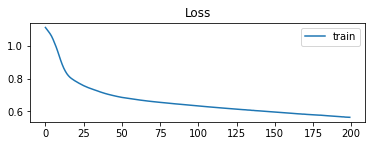

In [41]:
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
plt.legend()

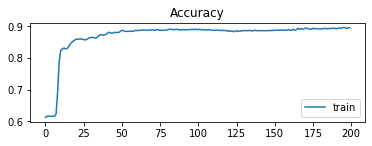

In [42]:
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
# plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
# pyplot.show()

In [188]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow import random
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import EarlyStopping


l1_param = 0.005
seed = 42
random.set_seed(seed)
np.random.seed(seed)
model = Sequential()

# Add the hidden dense layers and with dropout Layer
model.add(Dense(units=512, activation='relu', input_dim=X_train_sc.shape[1]))

model.add(Dense(units=128, activation='relu'))

model.add(Dense(units=64, activation='relu'))

model.add(Dense(units=32, activation='relu'))

model.add(Dense(units=16, activation='relu'))

model.add(Dense(units=8, activation='relu', ))


# Add Output Dense Layer
model.add(Dense(units=1, activation='sigmoid'))


In [189]:
opt = SGD(lr=0.001, momentum=0.9)
# Compile the Model
model.compile(optimizer= opt, loss='binary_crossentropy', metrics=['accuracy'])
es_callback = EarlyStopping(monitor='val_loss', \
                            mode='min', patience=10)

In [190]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 512)               17408     
_________________________________________________________________
dense_63 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_64 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_65 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_66 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_67 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_68 (Dense)             (None, 1)               

In [191]:
history = model.fit(X_train_sc, y_train, epochs=300, batch_size=32,callbacks=[es_callback], verbose=1, shuffle=False)

Epoch 1/300
28/28 [==============================] - 0s 2ms/step - loss: 0.6894 - accuracy: 0.6083
Epoch 2/300
28/28 [==============================] - 0s 2ms/step - loss: 0.6825 - accuracy: 0.6184
Epoch 3/300
28/28 [==============================] - 0s 3ms/step - loss: 0.6754 - accuracy: 0.6162
Epoch 4/300
28/28 [==============================] - 0s 3ms/step - loss: 0.6676 - accuracy: 0.6162
Epoch 5/300
28/28 [==============================] - 0s 3ms/step - loss: 0.6602 - accuracy: 0.6162
Epoch 6/300
28/28 [==============================] - 0s 2ms/step - loss: 0.6525 - accuracy: 0.6162
Epoch 7/300
28/28 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6162
Epoch 8/300
28/28 [==============================] - 0s 2ms/step - loss: 0.6332 - accuracy: 0.6162
Epoch 9/300
28/28 [==============================] - 0s 2ms/step - loss: 0.6209 - accuracy: 0.6162
Epoch 10/300
28/28 [==============================] - 0s 3ms/step - loss: 0.6069 - accuracy: 0.6162
Epoch 11/

28/28 [==============================] - 0s 2ms/step - loss: 0.3843 - accuracy: 0.8451
Epoch 28/300
28/28 [==============================] - 0s 2ms/step - loss: 0.3797 - accuracy: 0.8507
Epoch 29/300
28/28 [==============================] - 0s 2ms/step - loss: 0.3751 - accuracy: 0.8575
Epoch 30/300
28/28 [==============================] - 0s 2ms/step - loss: 0.3710 - accuracy: 0.8586
Epoch 31/300
28/28 [==============================] - 0s 2ms/step - loss: 0.3672 - accuracy: 0.8597
Epoch 32/300
28/28 [==============================] - 0s 2ms/step - loss: 0.3635 - accuracy: 0.8608
Epoch 33/300
28/28 [==============================] - 0s 2ms/step - loss: 0.3599 - accuracy: 0.8620
Epoch 34/300
28/28 [==============================] - 0s 3ms/step - loss: 0.3565 - accuracy: 0.8631
Epoch 35/300
28/28 [==============================] - 0s 2ms/step - loss: 0.3532 - accuracy: 0.8642
Epoch 36/300
28/28 [==============================] - 0s 2ms/step - loss: 0.3500 - accuracy: 0.8631
Epoch 37/300


28/28 [==============================] - 0s 2ms/step - loss: 0.3073 - accuracy: 0.8777
Epoch 55/300
28/28 [==============================] - 0s 2ms/step - loss: 0.3053 - accuracy: 0.8788
Epoch 56/300
28/28 [==============================] - 0s 2ms/step - loss: 0.3034 - accuracy: 0.8810
Epoch 57/300
28/28 [==============================] - 0s 2ms/step - loss: 0.3015 - accuracy: 0.8833
Epoch 58/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2998 - accuracy: 0.8844
Epoch 59/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2981 - accuracy: 0.8844
Epoch 60/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2966 - accuracy: 0.8844
Epoch 61/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2949 - accuracy: 0.8866
Epoch 62/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2934 - accuracy: 0.8855
Epoch 63/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2920 - accuracy: 0.8878
Epoch 64/300


28/28 [==============================] - 0s 2ms/step - loss: 0.2739 - accuracy: 0.8934
Epoch 81/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2732 - accuracy: 0.8934
Epoch 82/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2726 - accuracy: 0.8956
Epoch 83/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2721 - accuracy: 0.8923
Epoch 84/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2715 - accuracy: 0.8945
Epoch 85/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2710 - accuracy: 0.8934
Epoch 86/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2704 - accuracy: 0.8945
Epoch 87/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2700 - accuracy: 0.8945
Epoch 88/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2697 - accuracy: 0.8923
Epoch 89/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2691 - accuracy: 0.8923
Epoch 90/300


28/28 [==============================] - 0s 2ms/step - loss: 0.2639 - accuracy: 0.8934
Epoch 108/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2635 - accuracy: 0.8934
Epoch 109/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2635 - accuracy: 0.8934
Epoch 110/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2629 - accuracy: 0.8934
Epoch 111/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2629 - accuracy: 0.8934
Epoch 112/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2627 - accuracy: 0.8923
Epoch 113/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2625 - accuracy: 0.8934
Epoch 114/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2622 - accuracy: 0.8934
Epoch 115/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2621 - accuracy: 0.8934
Epoch 116/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2619 - accuracy: 0.8934
Epoc

28/28 [==============================] - 0s 2ms/step - loss: 0.2589 - accuracy: 0.8934
Epoch 134/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2586 - accuracy: 0.8934
Epoch 135/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2586 - accuracy: 0.8900
Epoch 136/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2586 - accuracy: 0.8923
Epoch 137/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2582 - accuracy: 0.8923
Epoch 138/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2579 - accuracy: 0.8911
Epoch 139/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2579 - accuracy: 0.8911
Epoch 140/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2575 - accuracy: 0.8911
Epoch 141/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2574 - accuracy: 0.8911
Epoch 142/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2569 - accuracy: 0.8911
Epoc

28/28 [==============================] - 0s 2ms/step - loss: 0.2539 - accuracy: 0.8923
Epoch 161/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2539 - accuracy: 0.8934
Epoch 162/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2538 - accuracy: 0.8923
Epoch 163/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2540 - accuracy: 0.8911
Epoch 164/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2534 - accuracy: 0.8923
Epoch 165/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2536 - accuracy: 0.8911
Epoch 166/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2531 - accuracy: 0.8923
Epoch 167/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2531 - accuracy: 0.8923
Epoch 168/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2533 - accuracy: 0.8911
Epoch 169/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2529 - accuracy: 0.8923
Epoc

28/28 [==============================] - 0s 2ms/step - loss: 0.2506 - accuracy: 0.8934
Epoch 187/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2503 - accuracy: 0.8945
Epoch 188/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2505 - accuracy: 0.8934
Epoch 189/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2499 - accuracy: 0.8945
Epoch 190/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2500 - accuracy: 0.8945
Epoch 191/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2497 - accuracy: 0.8945
Epoch 192/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2497 - accuracy: 0.8945
Epoch 193/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2494 - accuracy: 0.8934
Epoch 194/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2492 - accuracy: 0.8956
Epoch 195/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2493 - accuracy: 0.8956
Epoc

28/28 [==============================] - 0s 2ms/step - loss: 0.2464 - accuracy: 0.8979
Epoch 214/300
28/28 [==============================] - 0s 3ms/step - loss: 0.2461 - accuracy: 0.9001
Epoch 215/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2460 - accuracy: 0.9001
Epoch 216/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2457 - accuracy: 0.8990
Epoch 217/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2458 - accuracy: 0.8990
Epoch 218/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2455 - accuracy: 0.9001
Epoch 219/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2455 - accuracy: 0.9001
Epoch 220/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2454 - accuracy: 0.9001
Epoch 221/300
28/28 [==============================] - 0s 3ms/step - loss: 0.2453 - accuracy: 0.9001
Epoch 222/300
28/28 [==============================] - 0s 3ms/step - loss: 0.2450 - accuracy: 0.9001
Epoc

28/28 [==============================] - 0s 3ms/step - loss: 0.2421 - accuracy: 0.9024
Epoch 240/300
28/28 [==============================] - 0s 3ms/step - loss: 0.2424 - accuracy: 0.9024
Epoch 241/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2419 - accuracy: 0.9024
Epoch 242/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2421 - accuracy: 0.9012
Epoch 243/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2418 - accuracy: 0.9012
Epoch 244/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2415 - accuracy: 0.9024
Epoch 245/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2414 - accuracy: 0.9024
Epoch 246/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2412 - accuracy: 0.9024
Epoch 247/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2412 - accuracy: 0.9024
Epoch 248/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2407 - accuracy: 0.9024
Epoc

28/28 [==============================] - 0s 3ms/step - loss: 0.2385 - accuracy: 0.9024
Epoch 267/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2382 - accuracy: 0.9046
Epoch 268/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2383 - accuracy: 0.9024
Epoch 269/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2383 - accuracy: 0.9035
Epoch 270/300
28/28 [==============================] - 0s 3ms/step - loss: 0.2380 - accuracy: 0.9046
Epoch 271/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2380 - accuracy: 0.9046
Epoch 272/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2378 - accuracy: 0.9057
Epoch 273/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2375 - accuracy: 0.9046
Epoch 274/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2375 - accuracy: 0.9046
Epoch 275/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2376 - accuracy: 0.9068
Epoc

28/28 [==============================] - 0s 3ms/step - loss: 0.2356 - accuracy: 0.9057
Epoch 293/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2355 - accuracy: 0.9068
Epoch 294/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2354 - accuracy: 0.9057
Epoch 295/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2353 - accuracy: 0.9068
Epoch 296/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2350 - accuracy: 0.9057
Epoch 297/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2350 - accuracy: 0.9057
Epoch 298/300
28/28 [==============================] - 0s 3ms/step - loss: 0.2351 - accuracy: 0.9068
Epoch 299/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2349 - accuracy: 0.9057
Epoch 300/300
28/28 [==============================] - 0s 2ms/step - loss: 0.2349 - accuracy: 0.9046


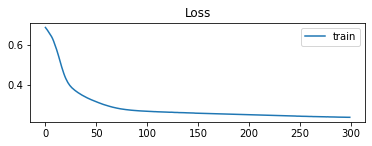

In [192]:
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
plt.legend()

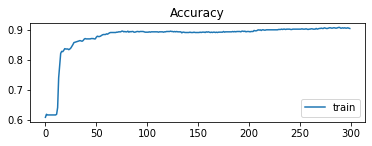

In [193]:
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
# plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
# pyplot.show()

In [43]:
prediction = model.predict(X_test_sc)

In [44]:
pred =np.round(prediction)

In [45]:
_, train_acc = model.evaluate(X_train_sc, y_train, verbose=0)

In [46]:
train_acc

0.8945005536079407

In [47]:
prediction = pd.DataFrame(pred, columns=['Survived'])

In [48]:
prediction.Survived.value_counts()

0.0    278
1.0    140
Name: Survived, dtype: int64

In [49]:
result = pd.concat([holdout['PassengerId'], prediction], axis=1)

In [50]:
result['Survived']=result['Survived'].astype('int64')

In [51]:
result.to_csv('submission_survived.csv', index=False)